# decision tree classifier

features:
- BlockDensity
- OtherPuzAns
- AnswerLength

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm #color maps
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
features = pd.read_csv('nick_df_features.csv',index_col=0)

features.sample(5)

,Date,Weekday,BlockDensity,OtherPuzAns,AnswerLength,WeekdayNum
7202,2013-12-29,Sunday,18.352941,7281,5.463768,6
1798,1998-12-28,Monday,18.666667,7596,4.692308,0
7355,2014-05-31,Saturday,10.666667,2519,6.090909,5
8210,2016-10-04,Tuesday,16.888889,5871,4.794872,1
9052,2019-01-24,Thursday,16.888889,5417,5.051282,3


In [3]:
class_labels = features.groupby(['WeekdayNum','Weekday']).size().reset_index()['Weekday'].tolist()

In [4]:
X = features[['BlockDensity','OtherPuzAns','AnswerLength']].to_numpy()
y = features[['WeekdayNum']].to_numpy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 617, 
                                                    shuffle=True,
                                                    stratify=y)

## cross-validation for max depth

In [6]:
# n will be the maximum max_depth I consider
kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=440)
n = 20

accs = np.zeros((5,n))
precs = np.zeros((5,n))
recs = np.zeros((5,n))

for j in range(1,n+1):
    tree_clf = DecisionTreeClassifier(max_depth=j, random_state=440)
    
    i=0
    for train_index, test_index in kfold.split(X_train,y_train):
        X_train_train, X_train_test = X_train[train_index], X_train[test_index]
        y_train_train, y_train_test = y_train[train_index], y_train[test_index]
        
        tree_clone = clone(tree_clf)
        tree_clone.fit(X_train_train, y_train_train)
        
        y_pred = tree_clone.predict(X_train_test)
        accs[i,j-1] = accuracy_score(y_train_test,y_pred)
        precs[i,j-1] = precision_score(y_train_test,y_pred,average='weighted',zero_division=0)
        recs[i,j-1] = recall_score(y_train_test,y_pred,average='weighted',zero_division=0)
        i = i + 1

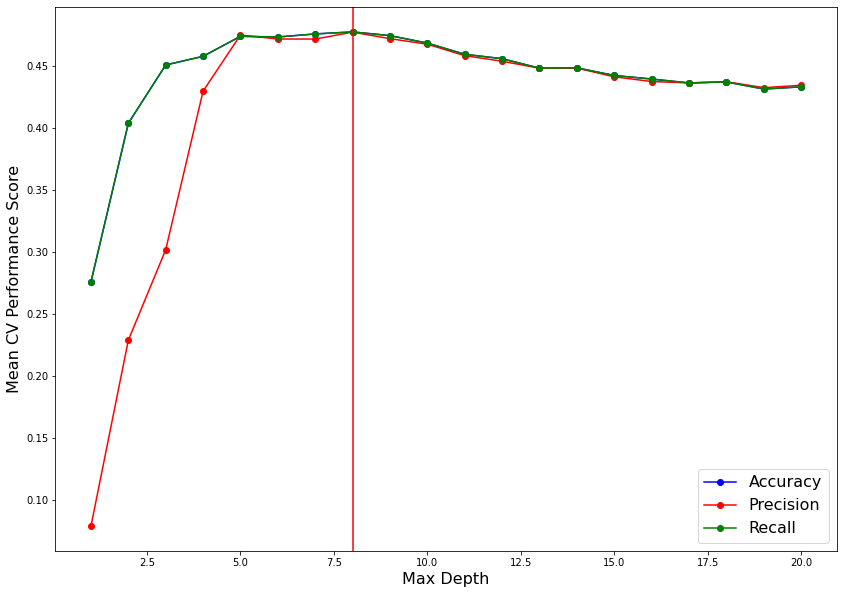

In [7]:
best_depth = np.argmax(np.mean(accs, axis=0))+1
plt.figure(figsize=(14,10))

plt.plot(range(1,n+1), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(1,n+1), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(1,n+1), np.mean(recs,axis=0),'g-o', label="Recall")
plt.axvline(x=best_depth, color='r')
#plt.annotate("best depth",(best_k+1,37.3), fontsize=14)
plt.ylabel("Mean CV Performance Score",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)

plt.legend(fontsize=16)

plt.show()

In [8]:
print(f"The highest accuraccy is in the model with a max depth of {best_depth}.")

The highest accuraccy is in the model with a max depth of 8.


## details on best model

In [9]:
tree_f = DecisionTreeClassifier(max_depth=best_depth, random_state=440)

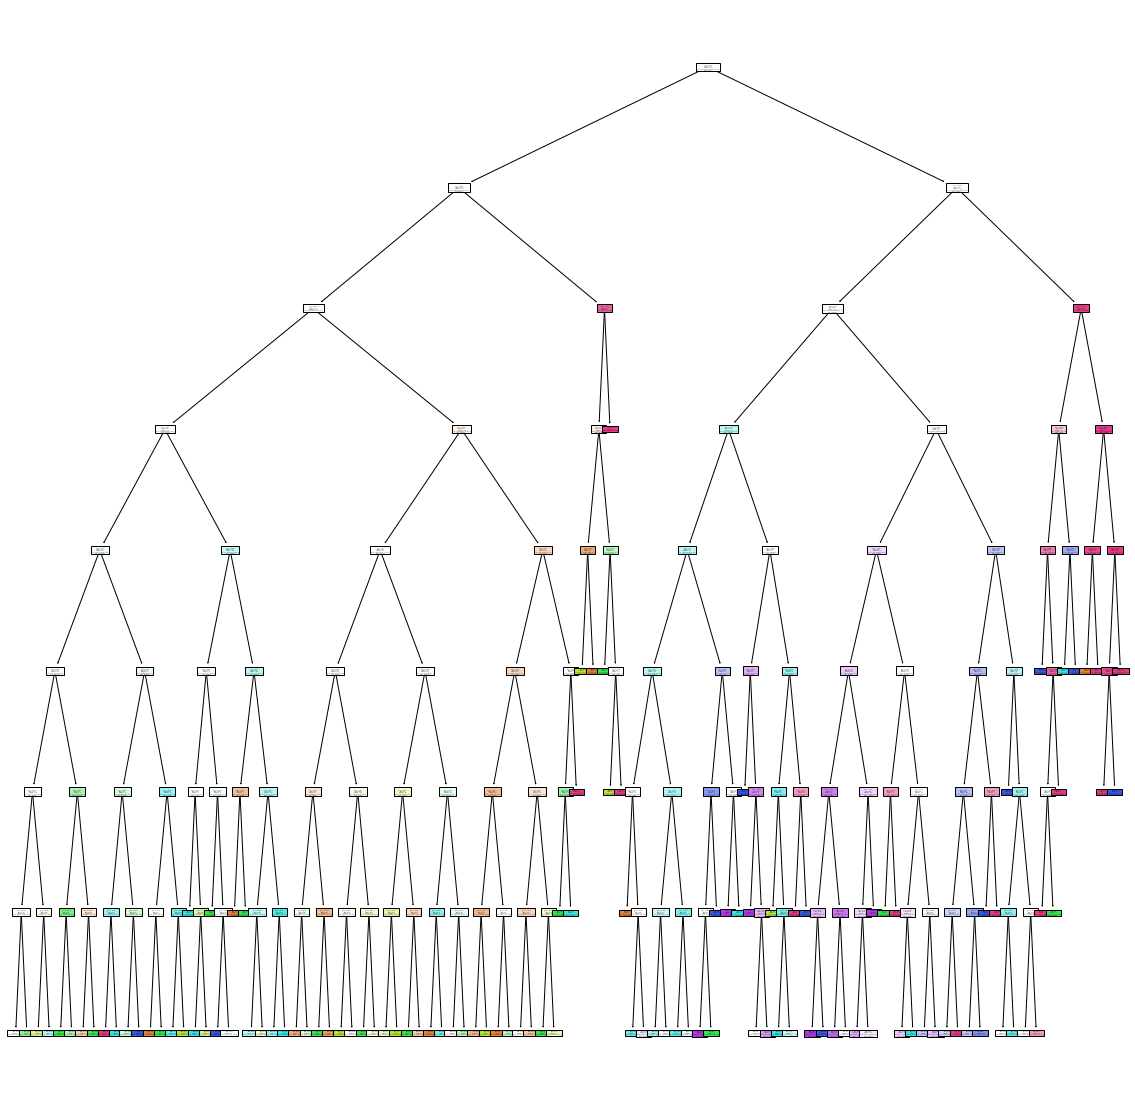

In [10]:
plt.figure(figsize = (20,20))
fig = tree_f.fit(X_test, y_test)
tree.plot_tree(fig,filled = True,class_names=class_labels)
plt.show()
#plt.savefig("tree2.pdf")

![](https://media1.tenor.com/images/3bde750c87550ccd238f9c567297872d/tenor.gif?itemid=3565289)

In [11]:
y_pred = tree_f.predict(X_test)
f_acc = accuracy_score(y_test,y_pred)
f_prec = precision_score(y_test,y_pred,average='micro')
f_rec = recall_score(y_test,y_pred,average='micro')
print(f"Overall scores:")
print(f"Accuracy:\t{np.round(f_acc*100,2)}%")
print(f"Precision:\t{np.round(f_prec*100,2)}%")
print(f"Recall:\t\t{np.round(f_rec*100,2)}%")

Overall scores:
Accuracy:	57.54%
Precision:	57.54%
Recall:		57.54%


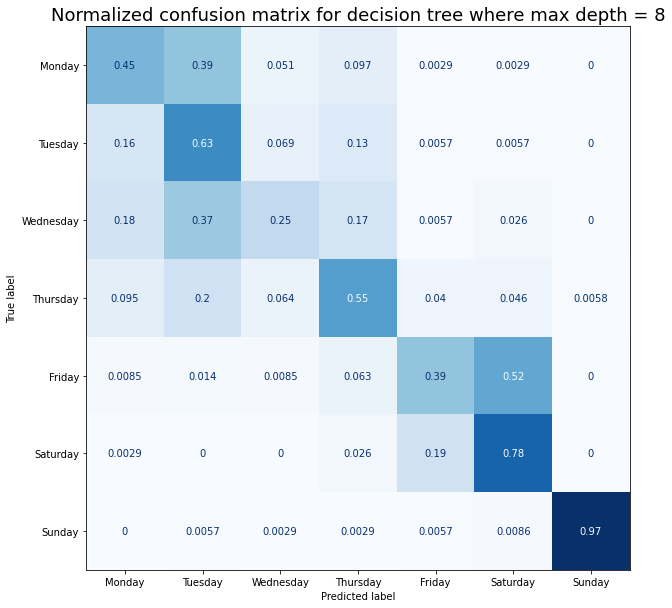

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(tree_f, X_test, y_test, 
                      display_labels=class_labels,
                      ax=ax, 
                      normalize='true',
                      cmap=cm.get_cmap('Blues'),
                      colorbar=False)
ax.set_title(f"Normalized confusion matrix for decision tree where max depth = {best_depth}", fontsize=18)
plt.show()